Load data

In [ ]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 3.13MB/s]


In [ ]:
!unzip titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
df = pd.read_csv('/content/train.csv', sep=',')

In [ ]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Preprocess

In [ ]:
df['Test'] = df['Name'].str.extract(r',\s([^.]+)\.')
df['Test'].unique()
df.groupby('Test').size().sort_values()

Test
Capt              1
Ms                1
Mme               1
Sir               1
Lady              1
the Countess      1
Don               1
Jonkheer          1
Major             2
Mlle              2
Col               2
Rev               6
Dr                7
Master           40
Mrs             125
Miss            182
Mr              517
dtype: int64

Let 's take only where there is more than 1 record

In [ ]:
def preprocess(df):
  #Change name
  df['Name'] = df['Name'].str.extract(r',\s([^.]+)\.')
  for index, name in enumerate(df['Name']):
    if name not in ['Major', 'Mlle', 'Col', 'Rev', 'Dr', 'Master', 'Mrs', 'Miss', 'Mr']:
        if df.loc[index, 'Sex'] == 'female':
            df.loc[index, 'Name'] = 'Mrs'
        else:
            df.loc[index, 'Name'] = 'Mr'

  #Get only TiketPrefix
  df['Ticket'] = df['Ticket'].str.extract(r'(\D+)(\d+)')[0]
  df['Ticket'] = df['Ticket'].str.replace(r'[^\w\s]', '').str.replace(' ', '').str[0]

  #Get only first char in cabin Name
  df['Cabin'] = df['Cabin'].str[0]
  return df

In [ ]:
df = preprocess(df)

In [ ]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Mr,male,22.0,1,0,A,7.2500,NaN,S
1,2,1,1,Mrs,female,38.0,1,0,P,71.2833,C,C
2,3,1,3,Miss,female,26.0,0,0,S,7.9250,NaN,S
3,4,1,1,Mrs,female,35.0,1,0,NaN,53.1000,C,S
4,5,0,3,Mr,male,35.0,0,0,NaN,8.0500,NaN,S


Next step to create Pipline for learning and fit

In [ ]:
numeric_cols = [
    'Age',
    'Fare'
]
categorical_cols = [
    'Pclass',
    'Name',
    'Sex',
    'SibSp',
    'Parch',
    'Ticket',
    'Cabin',
    'Embarked'
]
target_col = 'Survived'

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 3.0 MB/s eta 0:00:00


In [ ]:
np.linspace(0.1, 0.4, 6)

array([0.1 , 0.16, 0.22, 0.28, 0.34, 0.4 ])

In [ ]:
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

preprocessor = ColumnTransformer(
    transformers=[
        ('num', make_pipeline(SimpleImputer(strategy='mean'), StandardScaler(), MinMaxScaler()), numeric_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ]
)

rf = RandomForestClassifier()
gb = CatBoostClassifier()
lor = LogisticRegression()
kNN = KNeighborsClassifier()

ensemble = VotingClassifier(estimators=[('rf', rf), ('gb', gb), ('lor', lor), ('kNN', kNN)], voting='soft')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ensemble', ensemble)
])

param_grid = {
    'ensemble__rf__n_estimators': [50, 100, 200],
    'ensemble__gb__n_estimators': [50, 100, 200],
    'ensemble__gb__learning_rate': np.linspace(0.1, 0.4, 6),
    'ensemble__lor__C': [0.01, 0.1, 1, 10],
    'ensemble__kNN__n_neighbors': [3, 4, 5, 6]
}

model = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', cv=5)


In [ ]:
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Age',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['Pclass',
                                                                          'Name',
                                                                          'Sex',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Ticket',
                                                                          'Cabin',
                                                                          'Embarked'])])),
                                       ('ensemble',
                                        VotingCl...
                                                                      <catboost.core.CatBoostClassifier object at 0x79aa7b6abf10>),
                                                                     ('lor',
                                                                      LogisticRegression()),
                                                                     ('kNN',
                                                                      KNeighborsClassifier())],
                                                         voting='soft'))]),
             param_grid={'ensemble__gb__learning_rate': array([0.1 , 0.16, 0.22, 0.28, 0.34, 0.4 ]),
                         'ensemble__gb__n_estimators': [50, 100, 200],
                         'ensemble__kNN__n_neighbors': [3, 4, 5, 6],
                         'ensemble__lor__C': [0.01, 0.1, 1, 10],
                         'ensemble__rf__n_estimators': [50, 100, 200]},
             scoring='roc_auc')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[categorical_cols + numeric_cols], df[target_col], train_size=0.8)

In [ ]:
model.fit(X_train, y_train)

Выходные данные были обрезаны до нескольких последних строк (5000).
50:	learn: 0.1290940	total: 83.3ms	remaining: 243ms
51:	learn: 0.1280931	total: 85.1ms	remaining: 242ms
52:	learn: 0.1274552	total: 86.8ms	remaining: 241ms
53:	learn: 0.1242024	total: 88.5ms	remaining: 239ms
54:	learn: 0.1226979	total: 90.3ms	remaining: 238ms
55:	learn: 0.1225414	total: 92.2ms	remaining: 237ms
56:	learn: 0.1208475	total: 94ms	remaining: 236ms
57:	learn: 0.1193949	total: 95.5ms	remaining: 234ms
58:	learn: 0.1192986	total: 97.1ms	remaining: 232ms
59:	learn: 0.1191171	total: 98.7ms	remaining: 230ms
60:	learn: 0.1169737	total: 100ms	remaining: 228ms
61:	learn: 0.1135578	total: 102ms	remaining: 226ms
62:	learn: 0.1097042	total: 104ms	remaining: 225ms
63:	learn: 0.1077220	total: 105ms	remaining: 223ms
64:	learn: 0.1054791	total: 107ms	remaining: 221ms
65:	learn: 0.1052589	total: 108ms	remaining: 220ms
66:	learn: 0.1043442	total: 110ms	remaining: 218ms
67:	learn: 0.1023990	total: 112ms	remaining: 217ms
68:	le

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Age',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['Pclass',
                                                                          'Name',
                                                                          'Sex',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Ticket',
                                                                          'Cabin',
                                                                          'Embarked'])])),
                                       ('ensemble',
                                        VotingCl...
                                                                      <catboost.core.CatBoostClassifier object at 0x79aa7b6abf10>),
                                                                     ('lor',
                                                                      LogisticRegression()),
                                                                     ('kNN',
                                                                      KNeighborsClassifier())],
                                                         voting='soft'))]),
             param_grid={'ensemble__gb__learning_rate': array([0.1 , 0.16, 0.22, 0.28, 0.34, 0.4 ]),
                         'ensemble__gb__n_estimators': [50, 100, 200],
                         'ensemble__kNN__n_neighbors': [3, 4, 5, 6],
                         'ensemble__lor__C': [0.01, 0.1, 1, 10],
                         'ensemble__rf__n_estimators': [50, 100, 200]},
             scoring='roc_auc')

In [ ]:
idx = X_test[X_test['Parch'] == 6].index
X_test.loc[idx, 'Parch'] = 5

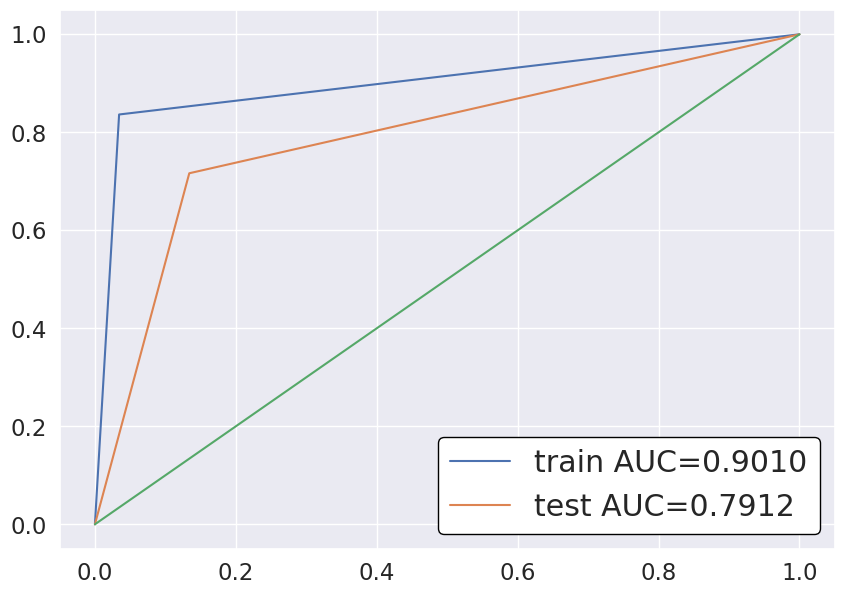

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [ ]:
df_sub = pd.read_csv('test.csv')
df_sub = preprocess(df_sub)
idx = df_sub[df_sub['Parch'] == 9].index
df_sub.loc[idx, 'Parch'] = 5
idx = df_sub[df_sub['Parch'] == 6].index
df_sub.loc[idx, 'Parch'] = 5
idx = df_sub[df_sub['Ticket'] == 'L'].index
df_sub.loc[idx, 'Ticket'] = np.nan

answ = model.predict(df_sub[categorical_cols + numeric_cols])

In [ ]:
answ

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
sub = pd.DataFrame({
        "PassengerId": df_sub["PassengerId"],
        "Survived": answ.astype(int)
    })

In [ ]:
sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [ ]:
sub.to_csv('my_answer.csv', index=False)